In [571]:
import numpy as np
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (ModelSpec as MS,
summarize,
poly)
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import LeaveOneOut, cross_val_score
from sklearn.utils import resample


In [384]:
from functools import partial
from sklearn.model_selection import \
(cross_validate,
KFold,
ShuffleSplit)
from sklearn.base import clone
from ISLP.models import sklearn_sm
from ISLP import confusion_table

In [385]:
#################labs
# Validation Set Approach 
Auto = load_data('Auto')
Auto['horsepower'] = pd.to_numeric(Auto['horsepower'], errors='coerce')
Auto_train, Auto_valid = train_test_split(Auto,
                                          test_size=196,
                                          random_state=0)

In [386]:
#fit a linear regression
hp_mm = MS(['horsepower'])
X_train = hp_mm.fit_transform(Auto_train)
y_train = Auto_train['mpg']
model = sm.OLS(y_train, X_train)
results1 = model.fit()

In [387]:
#predict() method of results evaluated
X_valid = hp_mm.transform(Auto_valid)
y_valid = Auto_valid['mpg']
valid_pred = results1.predict(X_valid)
np.mean((y_valid - valid_pred)**2)

23.61661706966988

In [388]:
#higher-degree polynomial regressions
def evalMSE(terms,
            response,
            train,
            test):
    mm = MS(terms)
    X_train = mm.fit_transform(train)
    y_train = train[response]
    X_test = mm.transform(test)
    y_test = test[response]
    results = sm.OLS(y_train, X_train).fit()
    test_pred = results.predict(X_test)
    return np.mean((y_test - test_pred)**2)

In [389]:
MSE = np.zeros(3)
for idx, degree in enumerate(range(1, 4)):
    MSE[idx] = evalMSE([poly('horsepower', degree)],
                       'mpg',
                       Auto_train,
                       Auto_valid)
MSE

array([23.61661707, 18.76303135, 18.79694163])

In [390]:
#estimate the validation MSE using linear, quadratic and cubic fits

In [391]:
#choose a different training/validation split
Auto_train, Auto_valid = train_test_split(Auto,
                                          test_size=196,
                                          random_state=3)
MSE = np.zeros(3)

for idx, degree in enumerate(range(1, 4)):
    MSE[idx] = evalMSE([poly('horsepower', degree)],
                       'mpg',
                       Auto_train,
                       Auto_valid)
    
MSE

array([20.75540796, 16.94510676, 16.97437833])

In [392]:
#predicts mpg using a quadratic function of horsepower performs better than linear&no evidence of that cubic better

In [393]:
#Cross-Validation
hp_model = sklearn_sm(sm.OLS,
                      MS(['horsepower']))
X, Y = Auto.drop(columns=['mpg']), Auto['mpg']
cv_results = cross_validate(hp_model,
                            X,
                            Y,
                            cv=Auto.shape[0])
cv_err = np.mean(cv_results['test_score'])
cv_err

24.23151351792924

In [394]:
cv_error = np.zeros(5)
H = np.array(Auto['horsepower'])
M = sklearn_sm(sm.OLS)
for i, d in enumerate(range(1,6)):
    X = np.power.outer(H, np.arange(d+1))
    M_CV = cross_validate(M,
                          X,
                          Y,
                          cv=Auto.shape[0])
    cv_error[i] = np.mean(M_CV['test_score'])
cv_error

array([24.23151352, 19.24821312, 19.33498406, 19.42443033, 19.03323827])

In [395]:
A = np.array([3, 5, 9])
B = np.array([2, 4])
np.add.outer(A, B)

array([[ 5,  7],
       [ 7,  9],
       [11, 13]])

In [396]:
######### use KFold() to partition the data into K = 10
cv_error = np.zeros(5)
cv = KFold(n_splits=10,
           shuffle=True,
           random_state=0) # use same splits for each degree
for i, d in enumerate(range(1,6)):
    X = np.power.outer(H, np.arange(d+1))
    M_CV = cross_validate(M,
                          X,
                          Y,
                          cv=cv)
    cv_error[i] = np.mean(M_CV['test_score'])
cv_error

array([24.20766449, 19.18533142, 19.27626666, 19.47848403, 19.13720581])

In [397]:
#validation set approach ShuffleSplit()
validation = ShuffleSplit(n_splits=1,
                          test_size=196,
                          random_state=0)
results = cross_validate(hp_model,
                         Auto.drop(['mpg'], axis=1),
                         Auto['mpg'],
                         cv=validation);
results['test_score']

array([23.61661707])

In [398]:
validation = ShuffleSplit(n_splits=10,
                          test_size=196,
                          random_state=0)
results = cross_validate(hp_model,
                         Auto.drop(['mpg'], axis=1),
                         Auto['mpg'],
                         cv=validation)
results['test_score'].mean(), results['test_score'].std()

(23.802232661034168, 1.421845094109185)

In [399]:
###############The Bootstrap

In [400]:
#estimate for α based on the selected observations
# input a dataframe D assumed to have columns X and Y
Portfolio = load_data('Portfolio')
def alpha_func(D, idx):
    cov_ = np.cov(D[['X','Y']].loc[idx], rowvar=False)
    return ((cov_[1,1] - cov_[0,1]) /
            (cov_[0,0]+cov_[1,1]-2*cov_[0,1]))

In [401]:
# estimates α using all 100 observations
alpha_func(Portfolio, range(100))

0.57583207459283

In [402]:
#randomly select 100 observations from range(100)
rng = np.random.default_rng(0) #seed
alpha_func(Portfolio,
           rng.choice(100, #given range 0 to 99, 100 is the given upper bound
                      100, #size of sample; how many items to choose
                      replace=True)) #the same number could be chosen multiple times in the sample

0.6074452469619004

In [403]:
#alternative
#a simple function boot_SE()
def boot_SE(func,
            D,
            n=None,
            B=1000,
            seed=0):
    rng = np.random.default_rng(seed)
    first_, second_ = 0, 0
    n = n or D.shape[0] #If n is not provided, it defaults to the number of rows in D
    for _ in range(B):#randomly selects n indices with replacement from the dataset indices
        idx = rng.choice(D.index,
                         n,
                         replace=True)
        value = func(D, idx)
        first_ += value
        second_ += value**2
    return np.sqrt(second_ / B - (first_ / B)**2)

In [404]:
#B = 1,000 bootstrap replications.
alpha_SE = boot_SE(alpha_func,
                   Portfolio,
                   B=1000,
                   seed=0)
alpha_SE

0.09118176521277699

In [405]:
#######Estimating the Accuracy of a Linear Regression Model

In [406]:
#boot_OLS() for bootstrapping a regression model
def boot_OLS(model_matrix, response, D, idx):
    D_ = D.loc[idx]
    Y_ = D_[response]
    X_ = clone(model_matrix).fit_transform(D_)
    return sm.OLS(Y_, X_).fit().params

In [407]:
#use partial() to freeze the first two model-formula arguments
hp_func = partial(boot_OLS, MS(['horsepower']), 'mpg')
hp_func?

Signature:      hp_func(D, idx)
Call signature: hp_func(*args, **kwargs)
Type:           partial
String form:    functools.partial(<function boot_OLS at 0x1501c2340>, ModelSpec(terms=['horsepower']), 'mpg')
File:           /opt/anaconda3/lib/python3.11/functools.py
Docstring:     
partial(func, *args, **keywords) - new function with partial application
of the given arguments and keywords.

In [408]:
#it has two arguments D and idx
#first two arguments frozen — and hence is ideal as the first argument

In [409]:
Auto.reset_index(drop=True, inplace=True)

In [410]:
rng = np.random.default_rng(0)
np.array([hp_func(Auto,
          rng.choice(392,
                     392,
                     replace = True)) for _ in range(10)])

array([[39.88064456, -0.1567849 ],
       [38.73298691, -0.14699495],
       [38.31734657, -0.14442683],
       [39.91446826, -0.15782234],
       [39.43349349, -0.15072702],
       [40.36629857, -0.15912217],
       [39.62334517, -0.15449117],
       [39.0580588 , -0.14952908],
       [38.66688437, -0.14521037],
       [39.64280792, -0.15555698]])

In [411]:
#use the boot_SE() function to compute the standard errors of 1,000 bootstrap
hp_se = boot_SE(hp_func,
                Auto,
                B=1000,
                seed=10)
hp_se

intercept     0.848807
horsepower    0.007352
dtype: float64

In [412]:
# compute the standard errors for the regression coeffcients in a linear model
hp_model.fit(Auto, Auto['mpg'])
model_se = summarize(hp_model.results_)['std err']
model_se

intercept     0.717
horsepower    0.006
Name: std err, dtype: float64

In [413]:
#different from bootstrap
# In fact,it suggests the opposite.
#depend on the unknown parameter σ2, the noise variance. We then estimate σ2 using the RSS.
# Now although the formula for the standard errors do not rely on the linear model being correct, the estimate for σ^2 does
# bootstrap approach does not rely on any of these assumptions

In [414]:
# estimates and the standard estimates of SE(βˆ0), SE(βˆ1) and SE(βˆ2).
quad_model = MS([poly('horsepower', 2, raw=True)])
quad_func = partial(boot_OLS,
                    quad_model,
                    'mpg')
boot_SE(quad_func, Auto, B=1000)

intercept                                  2.067840
poly(horsepower, degree=2, raw=True)[0]    0.033019
poly(horsepower, degree=2, raw=True)[1]    0.000120
dtype: float64

In [415]:
#using sm.OLS()
M = sm.OLS(Auto['mpg'],
quad_model.fit_transform(Auto))
summarize(M.fit())['std err']

intercept                                  1.800
poly(horsepower, degree=2, raw=True)[0]    0.031
poly(horsepower, degree=2, raw=True)[1]    0.000
Name: std err, dtype: float64

In [416]:
##############exercises

In [417]:
# 5.

In [418]:
Default = load_data('Default')

In [419]:
#a logistic regression model that uses income and balance to predict default
design = MS(['income','balance'])
X = design.fit_transform(Default)
y = Default.default == 'Yes'
glm = sm.Logit(y, X)
results = glm.fit()

Optimization terminated successfully.
         Current function value: 0.078948
         Iterations 10


In [420]:
#b.validation set approach to estimate the test error of this model

In [421]:
#i.Split
Default_train, Default_valid = train_test_split(Default,
                                          test_size=5000,
                                          random_state=0)

In [422]:
#ii.fit a multiple logistic regression model
hp_mm = MS(['income','balance'])
X_train = hp_mm.fit_transform(Default_train)
y_train = Default_train.default == 'Yes'
glm = sm.Logit(y_train, X_train)
results = glm.fit()

Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10


In [423]:
#iii.a prediction of default status for each individual in the validation set
#classifying the individual to the default category
X_valid = hp_mm.transform(Default_valid)
y_valid = Default_valid.default == 'Yes'
valid_pred = results.predict(X_valid)

labels = np.array(['No']*len(valid_pred), dtype=object)
labels[valid_pred >0.5] = "Yes"
y_valid_str = np.where(y_valid, "Yes", "No")

confusion_table(labels, y_valid_str)

Truth,No,Yes
Predicted,,
No,4801,132
Yes,13,54


In [424]:
np.mean(labels != y_valid_str)

0.029

In [425]:
#iv error rate
np.mean((y_valid - valid_pred)**2)

0.023279579914006296

In [426]:
#c.repeat 3 times
for i in range(16,20):
    Default_train, Default_valid = train_test_split(Default,
                                          test_size=5000,
                                          random_state=i)
    
    # Fit model
    hp_mm = MS(['income', 'balance'])
    X_train = hp_mm.fit_transform(Default_train)
    y_train = Default_train.default == 'Yes'
    glm = sm.Logit(y_train, X_train)
    results = glm.fit()
    
    # Predict on validation set
    X_valid = hp_mm.transform(Default_valid)
    y_valid = Default_valid.default == 'Yes'
    valid_pred = results.predict(X_valid)
    
    # Classification
    labels = np.array(['No'] * len(valid_pred), dtype=object)
    labels[valid_pred > 0.5] = "Yes"
    
    # Convert y_valid to string format
    y_valid_str = np.where(y_valid, "Yes", "No")
    
    # Confusion table
    conf_matrix = confusion_table(labels, y_valid_str)
    print(conf_matrix)
    
    # Misclassification rate
    misclassification_rate = np.mean(labels != y_valid_str)
    print(f"Misclassification rate: {misclassification_rate}")
    
    # Mean squared error (convert y_valid to integers)
    mse = np.mean((y_valid - valid_pred) ** 2)
    print(f"Mean Squared Error: {mse}")

Optimization terminated successfully.
         Current function value: 0.075882
         Iterations 10
Truth        No  Yes
Predicted           
No         4814  114
Yes          26   46
Misclassification rate: 0.028
Mean Squared Error: 0.02219440961867144
Optimization terminated successfully.
         Current function value: 0.081584
         Iterations 10
Truth        No  Yes
Predicted           
No         4818  102
Yes          22   58
Misclassification rate: 0.0248
Mean Squared Error: 0.020228685735075153
Optimization terminated successfully.
         Current function value: 0.083923
         Iterations 10
Truth        No  Yes
Predicted           
No         4819  103
Yes          20   58
Misclassification rate: 0.0246
Mean Squared Error: 0.019850515165212874
Optimization terminated successfully.
         Current function value: 0.080109
         Iterations 10
Truth        No  Yes
Predicted           
No         4822  106
Yes          23   49
Misclassification rate: 0.0258
Mean Sq

In [427]:
#illustrates the variability in the estimated test MSE

In [428]:
#d.
Default_train, Default_valid = train_test_split(Default,
                                          test_size=5000,
                                          random_state=0)

# Fit model
hp_mm = MS(['income', 'balance', 'student'])  # Include the 'student' variable
X_train = hp_mm.fit_transform(Default_train)
y_train = Default_train.default == 'Yes'
glm = sm.Logit(y_train, X_train)
results = glm.fit()
    
# Predict on validation set
X_valid = hp_mm.transform(Default_valid)
y_valid = Default_valid.default == 'Yes'
valid_pred = results.predict(X_valid)
    
# Classification
labels = np.array(['No'] * len(valid_pred), dtype=object)
labels[valid_pred > 0.5] = "Yes"
    
# Convert y_valid to string format
y_valid_str = np.where(y_valid, "Yes", "No")
    
# Confusion table
conf_matrix = confusion_table(labels, y_valid_str)
print(conf_matrix)
    
# Misclassification rate
misclassification_rate = np.mean(labels != y_valid_str)
print(f"Misclassification rate: {misclassification_rate}")
    
# Mean squared error (convert y_valid to integers)
mse = np.mean((y_valid - valid_pred) ** 2)
print(f"Mean Squared Error: {mse}")

Optimization terminated successfully.
         Current function value: 0.072293
         Iterations 10
Truth        No  Yes
Predicted           
No         4801  133
Yes          13   53
Misclassification rate: 0.0292
Mean Squared Error: 0.023250492462762333


In [429]:
# not including a dummy variable for student leads to a reduction in the test error rate.

In [430]:
#6.bootstrap &  computing the standard errors

In [431]:
#a.summarize() and sm.GLM()
design = MS(['income', 'balance'])
X = design.fit_transform(Default)
y = Default.default == 'Yes'
glm = sm.GLM(y, X, family=sm.families.Binomial())
results = glm.fit()
results.params

intercept   -11.540468
income        0.000021
balance       0.005647
dtype: float64

In [432]:
#b.boot_fn()
def boot_fn(D, response, model_matrix, idx):
    D_ = D.iloc[idx]  
    Y_ = D_[response] == 'Yes'
    X_ = clone(model_matrix).fit_transform(D_)
    return sm.GLM(Y_, X_, family=sm.families.Binomial()).fit().params[['income', 'balance']]

In [433]:
#c.estimate the standard errors of the logistic regression coefcients for income and balance
rng = np.random.default_rng(0)
bootstrap_results = np.array([boot_fn(Default,  
                                      'default',  # Response variable
                                      MS(['income', 'balance']),  # Model matrix
                                      rng.choice(len(Default), len(Default), replace=True))  # Bootstrap sample indices
                              for _ in range(10)])

In [434]:
bootstrap_results#coefficient

array([[1.87775777e-05, 5.73877605e-03],
       [3.20594655e-05, 6.16200434e-03],
       [1.59221870e-05, 5.61832222e-03],
       [1.40723398e-05, 5.41168597e-03],
       [1.12728778e-05, 5.70216361e-03],
       [1.85974460e-05, 5.83443562e-03],
       [1.52822182e-05, 5.53172383e-03],
       [1.73720495e-05, 5.70192972e-03],
       [2.33921172e-05, 5.28010522e-03],
       [1.50937413e-05, 5.46083916e-03]])

In [435]:
def logistic_func(D, idx):
    return boot_fn(D, 'default', MS(['income', 'balance']), idx)

In [436]:
logistic_se = boot_SE(logistic_func, Default, B=1000, seed=0)

In [437]:
logistic_se['income'],logistic_se['balance']

(4.7671997498212794e-06, 0.00023043534317812312)

In [438]:
results.bse['income'],results.bse['balance']

(4.985245458257297e-06, 0.0002273813844021023)

In [439]:
#the estimated standard errors are close 

In [440]:
#7.LOOCV
Weekly = load_data('Weekly')

In [441]:
#######a.logistic

In [442]:
model = MS(['Lag1','Lag2']).fit(Weekly)
X = model.transform(Weekly)
y = Weekly.Direction == 'Up'

glm = sm.GLM(y, X, family=sm.families.Binomial())
results = glm.fit()
summarize(results)

,coef,std err,z,P>|z|
intercept,0.2212,0.061,3.599,0.000
Lag1,-0.0387,0.026,-1.477,0.140
Lag2,0.0602,0.027,2.270,0.023


In [443]:
#####b.using all but the frst observation
Weekly_trimmed = Weekly.iloc[1:]
model = MS(['Lag1','Lag2']).fit(Weekly_trimmed)
X = model.transform(Weekly_trimmed)
y = Weekly_trimmed.Direction == 'Up'

glm = sm.GLM(y, X, family=sm.families.Binomial())
results = glm.fit()
summarize(results)

,coef,std err,z,P>|z|
intercept,0.2232,0.061,3.630,0.000
Lag1,-0.0384,0.026,-1.466,0.143
Lag2,0.0608,0.027,2.291,0.022


In [444]:
#c. predict the direction of the frst observation
X_first = model.transform(Weekly.iloc[[0]])
probs = results.predict(exog=X_first)
labels = np.array(['Down']*1)
labels[probs >0.5] = "Up"
actual_direction = Weekly.iloc[0].Direction
if labels[0] == actual_direction:
    print("The first observation was correctly classified.")
else:
    print("The first observation was incorrectly classified.")

The first observation was incorrectly classified.


In [445]:
#d.a for loop from i = 1 to i = n
n = len(Weekly)
errors = []

for i in range(n):
    Weekly_train = Weekly.drop(index=i)
    X_validate = model.transform(Weekly.iloc[[i]])
    
    model = MS(['Lag1','Lag2']).fit(Weekly_train)
    X = model.transform(Weekly_train)
    y = Weekly_train.Direction == 'Up'
    
    glm = sm.GLM(y, X, family=sm.families.Binomial())
    results = glm.fit()

      
    # Compute the posterior probability for the ith observation
    prob_up = results.predict(exog = X_validate) # Probability of market moving Up
    predicted_direction = np.array(['Down']*1)
    predicted_direction[prob_up >0.5] = "Up"
    actual_direction = Weekly.iloc[i].Direction

    # Determine if an error was made (1 for error, 0 for correct)
    error = 1 if predicted_direction != actual_direction else 0
    errors.append(error)

errors = np.array(errors)

# Output the total number of errors
print(errors[:10])
print(f"Total number of errors: {errors.sum()}")
print(f"Error rate: {errors.mean() * 100:.2f}%")

[1 1 0 1 0 1 0 0 0 1]
Total number of errors: 490
Error rate: 45.00%


In [546]:
#8.cross-validation
rng = np.random.default_rng(6)
x = rng.normal(size=100)
y = x - 2 * x**2 + rng.normal(size=100)

In [447]:
#x is a vector of 100 random numbers drawn from a standard normal distribution.
#y=x−2x^2+ϵ
#ϵ i ∼N(0,1) is the noise term, assumed to be normally distributed with mean 0 and variance 1.


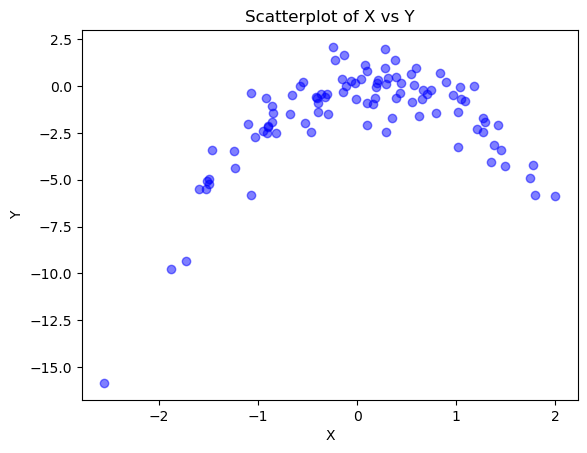

In [547]:
#b.
plt.scatter(x, y, color='blue', alpha=0.5)
plt.title('Scatterplot of X vs Y')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [548]:
#c.
np.random.seed(1)
cv_err = pd.Series()
for i in range(1, 5):
    poly_reg = Pipeline([("poly", PolynomialFeatures(degree = i)), ("reg", LinearRegression())])
    loo = LeaveOneOut()
    cv_scores = cross_val_score(poly_reg, x.reshape(-1, 1), y, scoring = "neg_mean_squared_error", cv = loo)
    cv_err.loc[i] = - np.mean(cv_scores.mean())
cv_err

1    6.652710
2    1.115958
3    1.100045
4    1.350448
dtype: float64

In [549]:
#d
np.random.seed(6)
for i in range(1, 5):
    poly_reg = Pipeline([("poly", PolynomialFeatures(degree = i)), ("reg", LinearRegression())])
    loo = LeaveOneOut()
    cv_scores = cross_val_score(poly_reg, x.reshape(-1, 1), y, scoring = "neg_mean_squared_error", cv = loo)
    cv_err.loc[i] = - np.mean(cv_scores.mean())
cv_err

1    6.652710
2    1.115958
3    1.100045
4    1.350448
dtype: float64

In [ ]:
#the seed has no effect

In [ ]:
#e model 3 cubic

In [555]:
data = pd.DataFrame({'X': x, 'Y': y})

for i in range(1, 5):
    X = MS([poly('X', degree=i)]).fit_transform(data)
    model = sm.OLS(data['Y'], X)
    
    print(summarize(model.fit()))
    

                     coef  std err      t  P>|t|
intercept         -1.6483    0.249 -6.616  0.000
poly(X, degree=1)  8.8425    2.491  3.549  0.001
                         coef  std err       t  P>|t|
intercept             -1.6483    0.104 -15.840    0.0
poly(X, degree=2)[0]   8.8425    1.041   8.498    0.0
poly(X, degree=2)[1] -22.4332    1.041 -21.558    0.0
                         coef  std err       t  P>|t|
intercept             -1.6483    0.104 -15.897  0.000
poly(X, degree=3)[0]   8.8425    1.037   8.529  0.000
poly(X, degree=3)[1] -22.4332    1.037 -21.637  0.000
poly(X, degree=3)[2]   1.3551    1.037   1.307  0.194
                         coef  std err       t  P>|t|
intercept             -1.6483    0.104 -15.863  0.000
poly(X, degree=4)[0]   8.8425    1.039   8.510  0.000
poly(X, degree=4)[1] -22.4332    1.039 -21.589  0.000
poly(X, degree=4)[2]   1.3551    1.039   1.304  0.195
poly(X, degree=4)[3]  -0.7902    1.039  -0.760  0.449


In [ ]:
#Yes the results agree with LOOCV

In [ ]:
########9

In [559]:
Boston = load_data("Boston")

In [577]:
mean = np.mean(Boston['medv'])
mean

22.532806324110677

In [581]:
#b
SE = Boston['medv'].std()/np.sqrt(len(Boston['medv']))
SE

0.4088611474975351

In [ ]:
#c bootstrap

In [575]:
rng = np.random.default_rng(0)

# Bootstrap setup for custom function
bootstrap_means = []



for _ in range(10000):
    boot_sample = resample(Boston['medv'])
    bootstrap_means.append(boot_sample.mean())
    
SE_bootstrap = np.std(bootstrap_means, ddof=1)

SE_bootstrap



0.40958658058390807

In [576]:
#close to the true SE

In [ ]:
#d.a 95 % confdence interval for the mean of medv

In [582]:
[mean - 2*SE,mean + 2*SE]

[21.715084029115605, 23.35052861910575]

In [583]:
conf_interval_bootstrap = [
    np.percentile(bootstrap_means, 2.5),
    np.percentile(bootstrap_means, 97.5)
]
conf_interval_bootstrap

[21.737747035573125, 23.338142292490115]

In [584]:
#
µˆmed = Boston['medv'].median()
µˆmed

21.2

In [586]:
#f
bootstrap_medians = []

for _ in range(10000):
    boot_sample = resample(Boston['medv'])
    bootstrap_medians.append(boot_sample.median())

SE_med = np.std(bootstrap_medians, ddof=1)

SE_med

0.37710540996387487

In [587]:
#g
np.percentile(Boston['medv'], 10)

12.75

In [588]:
#h
bootstrap_tenth = []

for _ in range(10000):
    boot_sample = resample(Boston['medv'])
    bootstrap_tenth.append(np.percentile(boot_sample, 10))

SE_tenth = np.std(bootstrap_tenth, ddof=1)

SE_tenth

0.5008641348591041